In [2]:
#!/usr/bin/env python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from teamName import getMyPosition as getPosition

nInst = 0
nt = 0
commRate = 0.0010
dlrPosLimit = 10000

def loadPrices(fn):
    global nt, nInst
    df = pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    (nt, nInst) = df.shape
    return (df.values).T


pricesFile = "./prices.txt"
prcAll = loadPrices(pricesFile)
print("Loaded %d instruments for %d days" % (nInst, nt))

def calcPL(prcHist):
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_, nt) = prcHist.shape
    for t in range(250, 501):
        prcHistSoFar = prcHist[:, :t]
        newPosOrig = getPosition(prcHistSoFar)
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits)
        deltaPos = newPos - curPos
        dvolumes = curPrices * np.abs(deltaPos)
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume
        comm = dvolume * commRate
        cash -= curPrices.dot(deltaPos) + comm
        curPos = np.array(newPos)
        posValue = curPos.dot(curPrices)
        todayPL = cash + posValue - value
        todayPLL.append(todayPL)
        value = cash + posValue
        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        # print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
        #      (t, value, todayPL, totDVolume, ret))
    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)


(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

Loaded 50 instruments for 500 days
=====
mean(PL): -0.2
return: -0.00090
StdDev(PL): 0.77
annSharpe(PL): -3.88 
totDvolume: 52451 
Score: -0.27


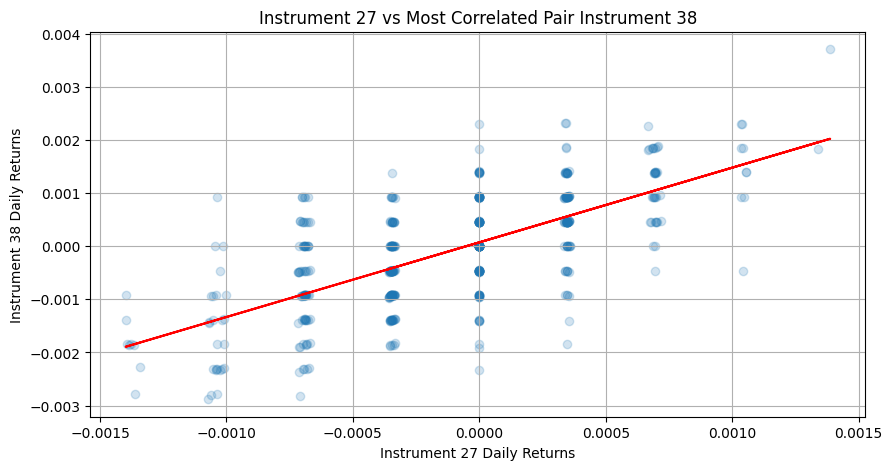

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     941.4
Date:                Sat, 29 Jun 2024   Prob (F-statistic):          7.37e-117
Time:                        19:56:51   Log-Likelihood:                -92.210
No. Observations:                 500   AIC:                             188.4
Df Residuals:                     498   BIC:                             196.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8168      1.099     -4.381      0.0

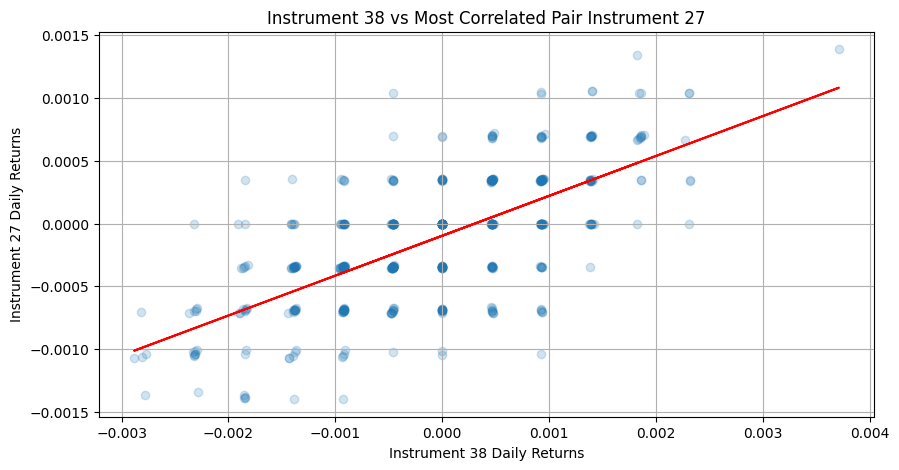

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     941.4
Date:                Sat, 29 Jun 2024   Prob (F-statistic):          7.37e-117
Time:                        19:56:51   Log-Likelihood:                 237.82
No. Observations:                 500   AIC:                            -471.6
Df Residuals:                     498   BIC:                            -463.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4709      0.394     24.043      0.0

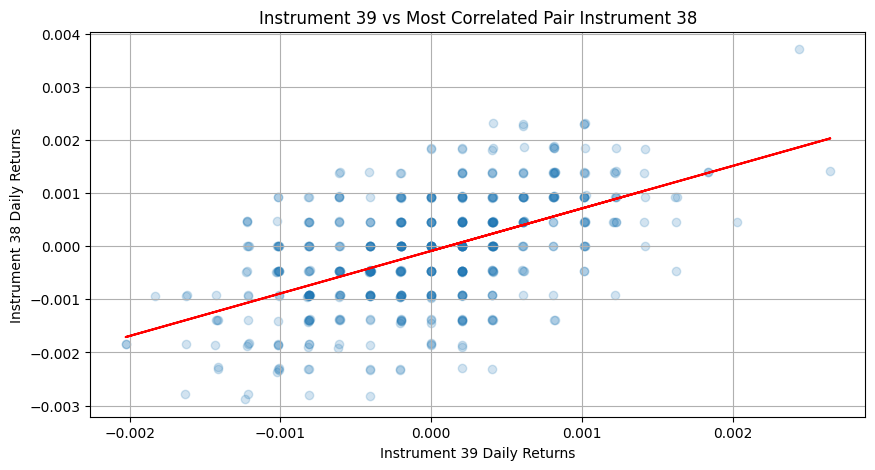

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     493.7
Date:                Sat, 29 Jun 2024   Prob (F-statistic):           1.66e-76
Time:                        19:56:51   Log-Likelihood:                 194.60
No. Observations:                 500   AIC:                            -385.2
Df Residuals:                     498   BIC:                            -376.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.4542      0.619     57.231      0.0

In [3]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
# Calculate daily returns
daily_returns = np.diff(prcAll) / prcAll[:, :-1]

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(daily_returns)

# Find the most correlated pair for each instrument
most_correlated_pairs = {}
for i in range(correlation_matrix.shape[0]):
    # Exclude self-correlation by setting the diagonal to -inf
    corr_with_others = correlation_matrix[i, :].copy()
    corr_with_others[i] = -np.inf
    most_correlated_index = np.argmax(corr_with_others)
    most_correlated_pairs[i] = most_correlated_index


for instrument, correlated_pair in most_correlated_pairs.items():
    if (correlation_matrix[instrument, correlated_pair]) < 0.5:
        continue
    plt.figure(figsize=(10, 5))
    plt.scatter(daily_returns[instrument], daily_returns[correlated_pair], alpha=0.2)
    plt.title(f'Instrument {instrument} vs Most Correlated Pair Instrument {correlated_pair}')
    plt.xlabel(f'Instrument {instrument} Daily Returns')
    plt.ylabel(f'Instrument {correlated_pair} Daily Returns')

    x = daily_returns[instrument]
    y = daily_returns[correlated_pair]
    slope, intercept = np.polyfit(x, y, 1)
    line = slope * x + intercept
    plt.plot(x, line, color='red', label='Line of Best Fit')

    plt.grid(True)
    plt.show()

    # Perform OLS regression on prices
    X = sm.add_constant(prcAll[correlated_pair])
    y = prcAll[instrument]
    model = sm.OLS(y, X).fit()
    residuals = model.resid

    print(model.summary())

    # Perform the ADF test on the residuals
    result = adfuller(residuals)

    # Print the results of the ADF test
    print(f'ADF Statistic for Instrument {instrument} vs {correlated_pair}: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    if result[1] < 0.05:
        print(f'The residuals are stationary, indicating the series {instrument} and {correlated_pair} are cointegrated.')
    else:
        print(f'The residuals are not stationary, indicating the series {instrument} and {correlated_pair} are not cointegrated.')


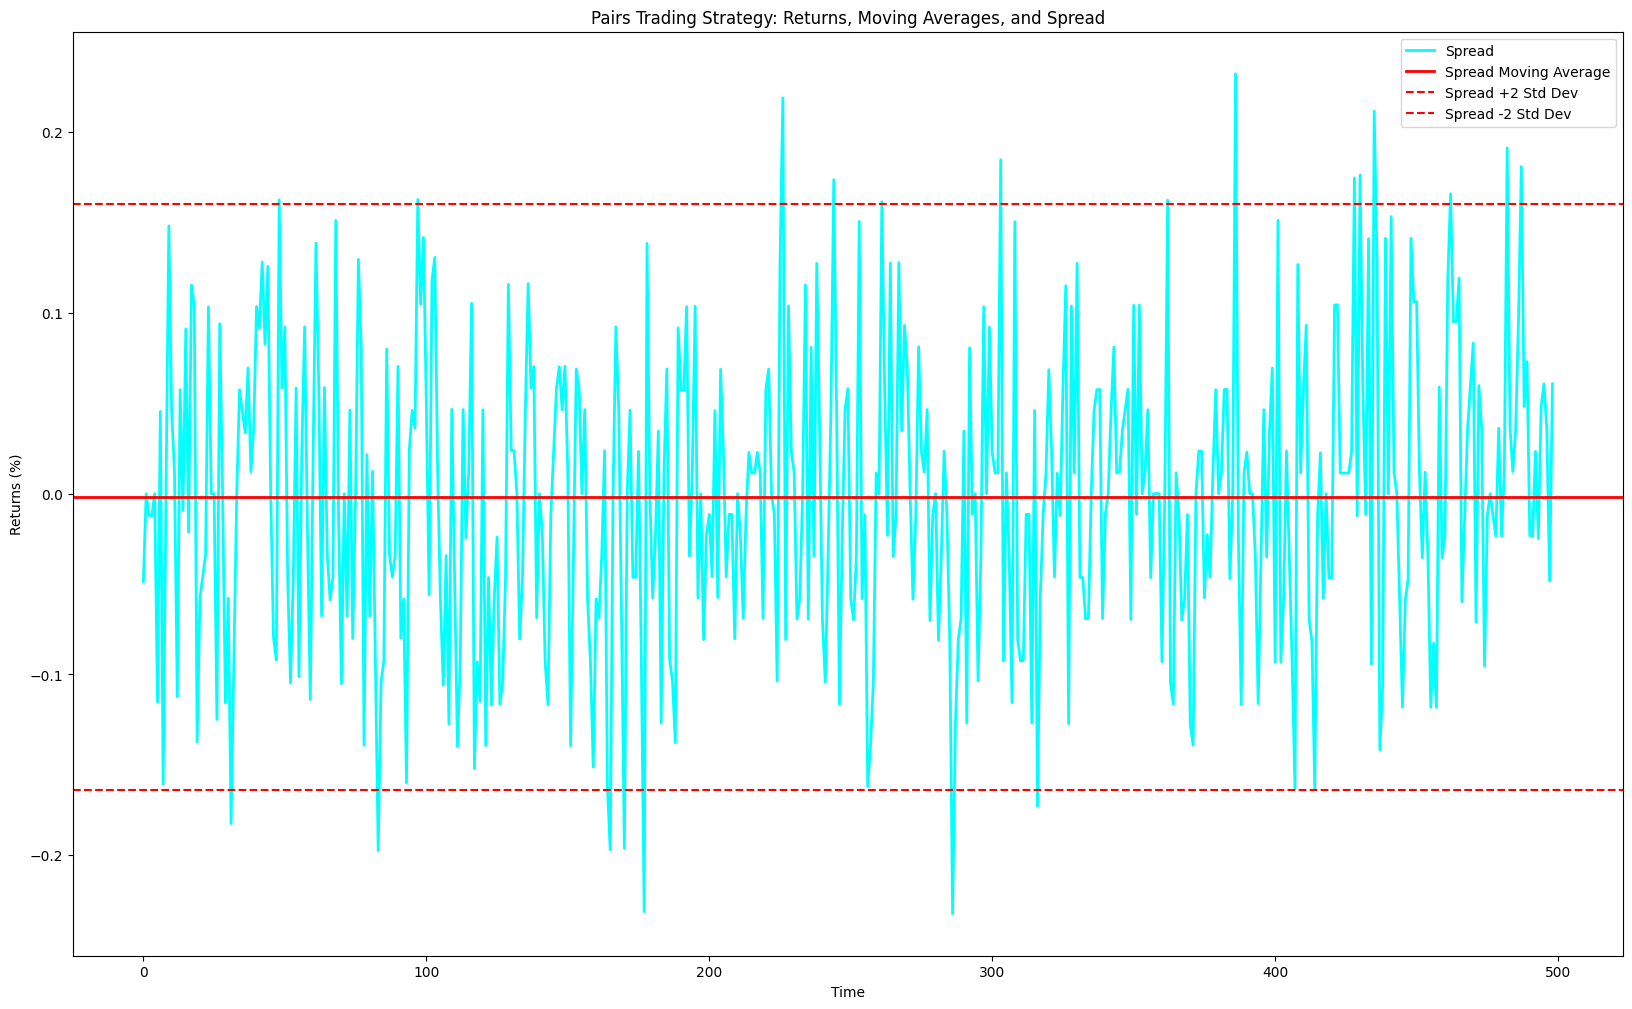

In [6]:
from itertools import cycle 
window_size = 250
instrument_pairs = [27, 38]
adjustment = 50

# Calculate percentage returns
returns = np.diff(prcAll, axis=1) / prcAll[:, :-1] * 100

# Calculate rolling window statistics
rolling_window1 = returns[instrument_pairs[0], -window_size:]
rolling_window2 = returns[instrument_pairs[1], -window_size:]

moving_average1 = np.mean(rolling_window1)
moving_average2 = np.mean(rolling_window2)

spread = returns[instrument_pairs[0], -1] - returns[instrument_pairs[1], -1]
spread_moving_average = moving_average1 - moving_average2
spread_std_dev = np.std(rolling_window1 - rolling_window2)

# Plotting
instruments_to_plot = [27, 38]
colors = cycle(['b', 'k', 'r', 'c', 'm', 'y', 'k'])
plt.figure(figsize=(20, 12))

daily_returns = np.diff(prcAll, axis=1) / prcAll[:, :-1] * 100

""" df = pd.DataFrame(daily_returns.T)
window_size_plot = 100
moving_averages = df.rolling(window=window_size_plot).mean()
moving_std_devs = df.rolling(window=window_size_plot).std()
 """
for i in instruments_to_plot:
    color = next(colors)
    mean_price = np.mean(daily_returns[i, :])
    std_dev = np.std(daily_returns[i, :])
    #plt.plot(daily_returns[i, :], color=color, label=f'Instrument {i} Returns')
    #plt.plot(moving_averages[i], color=color, label=f'Instrument {i} Moving Average')
   # plt.plot(moving_averages[i] + 1 * moving_std_devs[i], color=color, linestyle=':', label=f'Instrument {i} +1 Std Dev')
    #plt.plot(moving_averages[i] - 1 * moving_std_devs[i], color=color, linestyle=':', label=f'Instrument {i} -1 Std Dev')

# Adding spread plot
spread_values = returns[instrument_pairs[0]] - returns[instrument_pairs[1]]
moving_average_spread = np.mean(spread_values[:])
std_dev_spread = np.std(spread_values[:])

plt.plot(spread_values, color='cyan', label='Spread', linewidth=2)
plt.axhline(y=moving_average_spread, color='red', linestyle='-', linewidth=2, label='Spread Moving Average')
plt.axhline(y=moving_average_spread + 2.5 * std_dev_spread, color='red', linestyle='--', label='Spread +2 Std Dev')
plt.axhline(y=moving_average_spread - 2.5 * std_dev_spread, color='red', linestyle='--', label='Spread -2 Std Dev')

plt.xlabel('Time')
plt.ylabel('Returns (%)')
plt.title('Pairs Trading Strategy: Returns, Moving Averages, and Spread')
plt.legend()
plt.show()

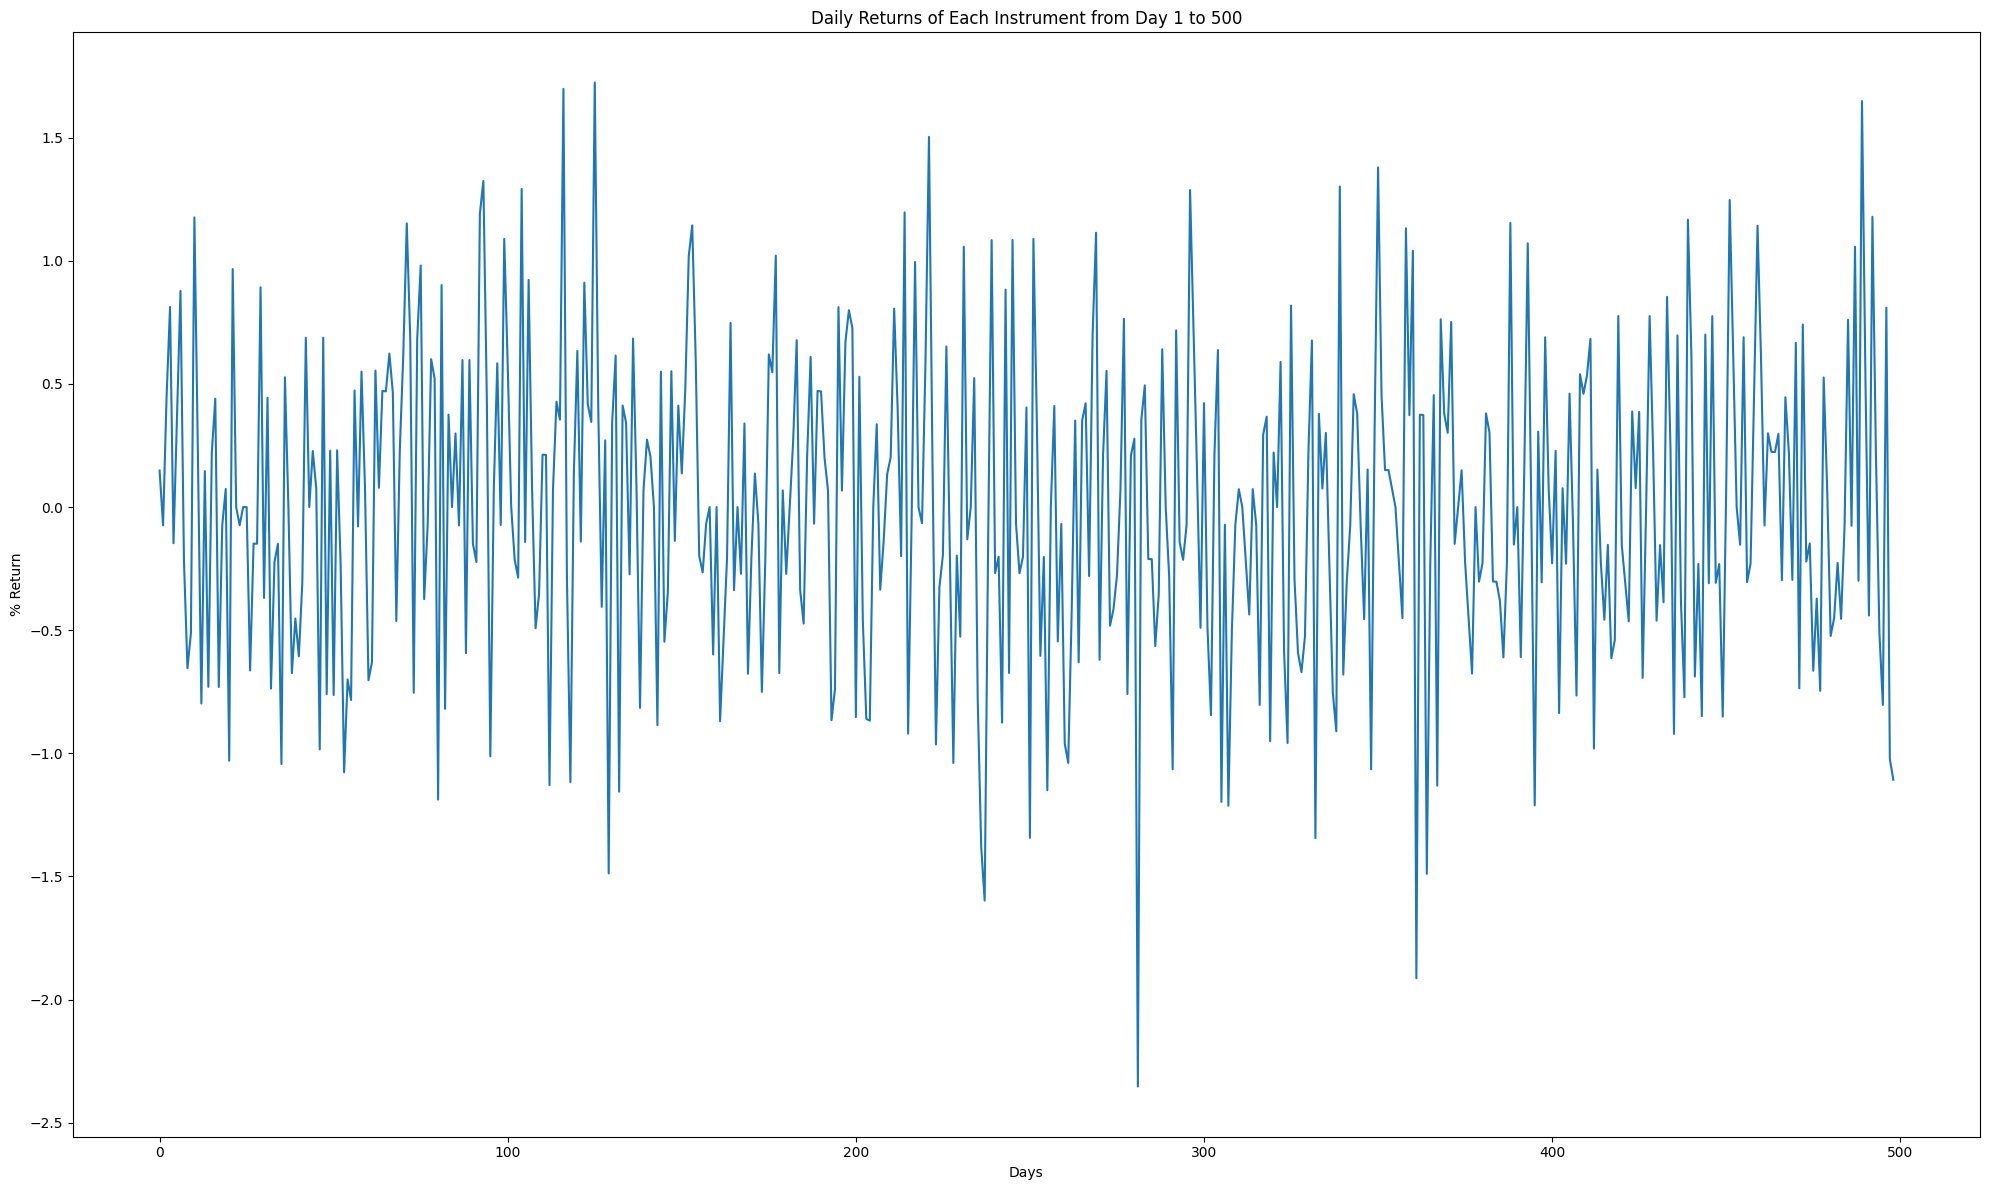

In [5]:
instruments_to_plot = [0]

daily_returns = np.diff(prcAll) / prcAll[:, :-1]

plt.figure(figsize=(20,12))
for i in instruments_to_plot:
    plt.plot(100 * daily_returns[i, :])

plt.xlabel('Days')
plt.ylabel('% Return')
plt.title('Daily Returns of Each Instrument from Day 1 to 500')
plt.tight_layout()
plt.show()

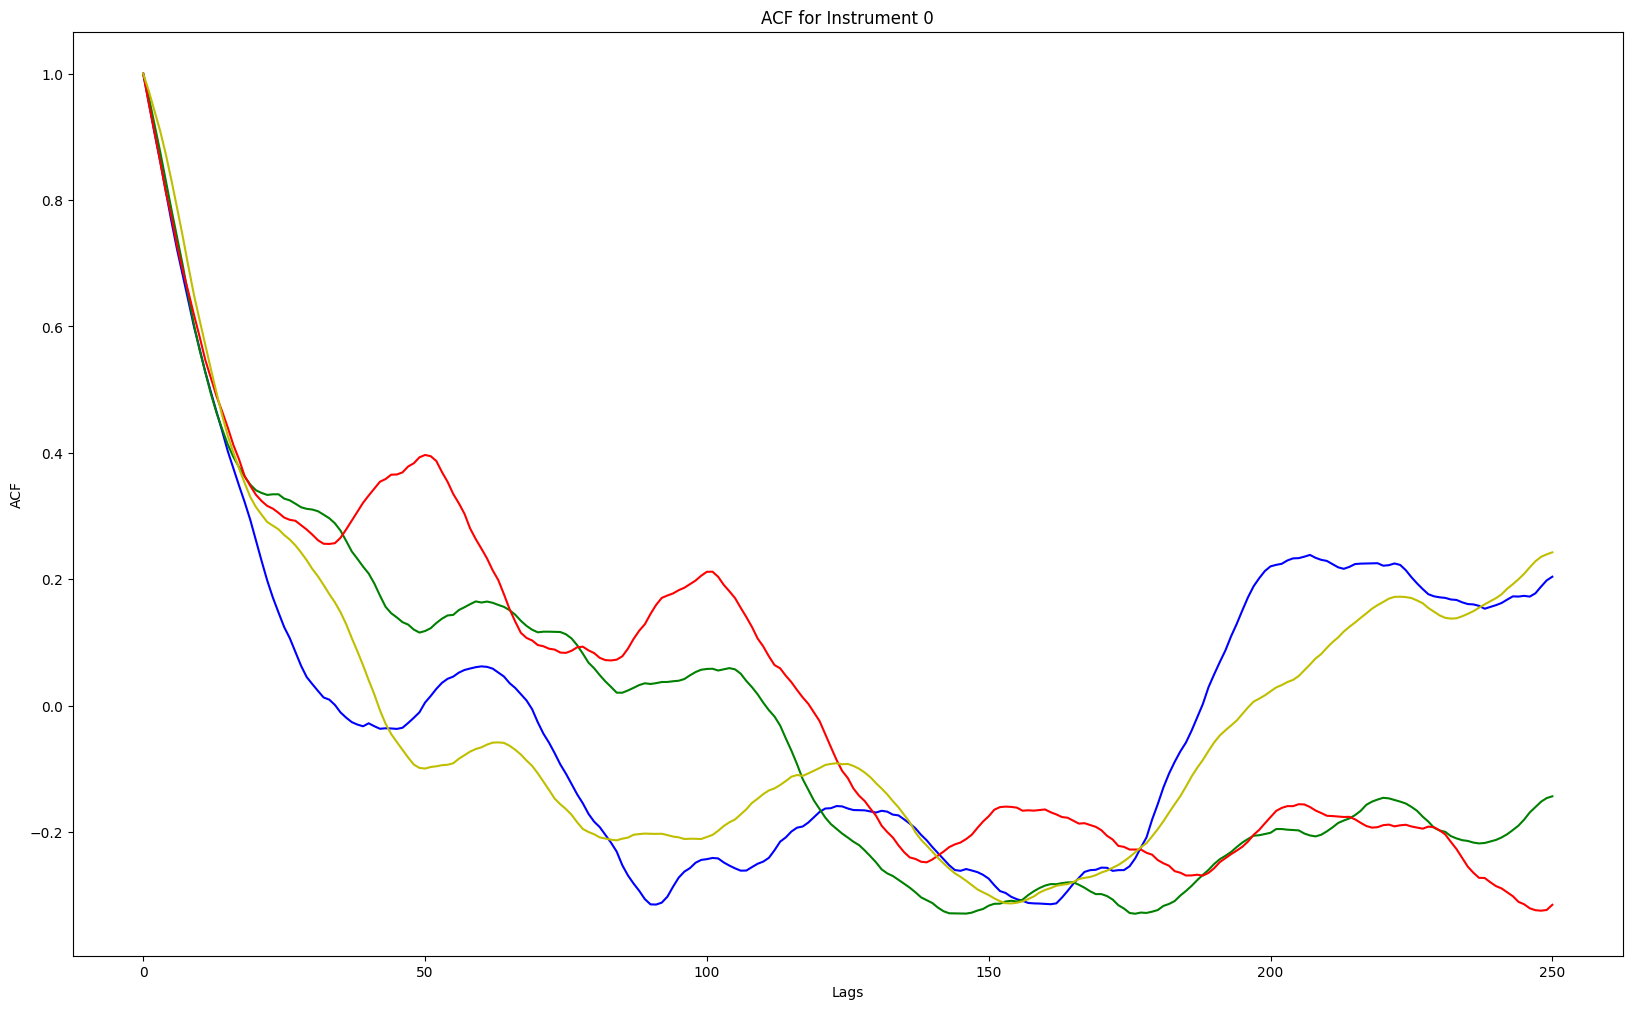

In [6]:
from statsmodels.tsa.stattools import acf

colors = cycle(['b', 'g', 'r', 'y'])
instruments_to_plot = [7,28,43,49]
plt.figure(figsize=(20, 12))
# Calculate ACF for each instrument
acf_values = [acf(prcAll[i, :], nlags=250) for i in instruments_to_plot]
for i in range(4):
    color = next(colors)
    plt.plot(acf_values[i], color=color, label=f'Instrument {i}')

# Plot ACF for the first instrument as an example
plt.title('ACF for Instrument 0')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test and print results
def perform_adf_test(series, instrument_index):
    result = adfuller(series)
    print(f'p-value for Instrument {instrument_index}: {result[1]}')

for i in range(nInst):
    # Get the price series for the specific instrument
    price_series = prcAll[i, :]
    # Perform the ADF test on the price series
    perform_adf_test(price_series, i)

p-value for Instrument 0: 0.6390322899010249
p-value for Instrument 1: 0.6666278254838212
p-value for Instrument 2: 0.34875262672757923
p-value for Instrument 3: 0.8727250227260919
p-value for Instrument 4: 0.5175258939328804
p-value for Instrument 5: 0.8345039011947037
p-value for Instrument 6: 0.08429036432772136
p-value for Instrument 7: 0.009410264417328689
p-value for Instrument 8: 0.09016470625230844
p-value for Instrument 9: 0.8465044888508644
p-value for Instrument 10: 0.7114287541892675
p-value for Instrument 11: 0.25226687091497274
p-value for Instrument 12: 0.7072147028056796
p-value for Instrument 13: 0.8547904546142773
p-value for Instrument 14: 0.3271639920519112
p-value for Instrument 15: 0.6209896606511506
p-value for Instrument 16: 0.8772566778932676
p-value for Instrument 17: 0.17720351114330124
p-value for Instrument 18: 0.995375138340169
p-value for Instrument 19: 0.32319173660813283
p-value for Instrument 20: 0.27956284122012065
p-value for Instrument 21: 0.5191095